In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.utils import check_array
import xgboost as xgb
import model_dispatcher
import config

import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import pickle

In [2]:
model_dispatcher.models['XGboost']

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None)

In [3]:
# read the csv file
file_path = "D:\Murtaza\machine_learning_projects\mlframework\PrognosixAG-CaseStudy\input/"
df = pd.read_csv(file_path + "tomatoesAndFeatures.csv", delimiter=';', parse_dates=['date'])
df = df.sort_values(by="date")

In [4]:
# dropping redundant columns

columns = [
    'date',
    'seasonName', 
    'newSnowDescription',
    'rainDescription',
    'sunShineDescription',
    'temperatureDescription',
    'weekDayDescription',
]

df_new = df.drop(columns, axis=1)

In [5]:
df_new.head()

,salesAmount,promotionYes,bridgeDayYes,publicHolidayYes,seasonCode,calendarWeek,newSnowCode,rainCode,sunshineCode,temperaturCode,shopsClosedYes,weekdayCode
0,4574,0,0,0,3,44,0,4,5,4,0,5
1,6531,0,0,0,3,44,0,4,4,5,0,6
2,7291,0,0,0,3,44,0,3,5,5,0,7
3,611,0,0,0,3,44,0,5,4,5,1,1
4,4732,0,0,0,3,45,0,5,4,4,0,2


## FEATURE GENERATION

In [6]:
fig = px.line(df, x='date', y='salesAmount', title='Amount of Sales')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [7]:
# create a new dataframe to model the difference 
df_diff = df.copy()

# add previous sales to the next row
df_diff['prev_sales'] = df_diff['salesAmount'].shift(1)

# drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['salesAmount'] - df_diff['prev_sales'])

In [8]:
df_diff.head()

,date,salesAmount,promotionYes,bridgeDayYes,publicHolidayYes,seasonCode,seasonName,calendarWeek,newSnowCode,newSnowDescription,...,rainDescription,sunshineCode,sunShineDescription,temperaturCode,temperatureDescription,shopsClosedYes,weekdayCode,weekDayDescription,prev_sales,diff
1,2012-11-02,6531,0,0,0,3,Herbst,44,0,kein Schnee,...,feuchter als Mittel,4,mehr als Mittel,5,viel waermer als Mittel,0,6,Freitag,4574.0,1957.0
2,2012-11-03,7291,0,0,0,3,Herbst,44,0,kein Schnee,...,Mittel,5,viel mehr als Mittel,5,viel waermer als Mittel,0,7,Samstag,6531.0,760.0
3,2012-11-04,611,0,0,0,3,Herbst,44,0,kein Schnee,...,viel feuchter als Mittel,4,mehr als Mittel,5,viel waermer als Mittel,1,1,Sonntag,7291.0,-6680.0
4,2012-11-05,4732,0,0,0,3,Herbst,45,0,kein Schnee,...,viel feuchter als Mittel,4,mehr als Mittel,4,waermer als Mittel,0,2,Montag,611.0,4121.0
5,2012-11-06,4270,0,0,0,3,Herbst,45,0,kein Schnee,...,feuchter als Mittel,3,Mittel,2,kaelter als Mittel,0,3,Dienstag,4732.0,-462.0


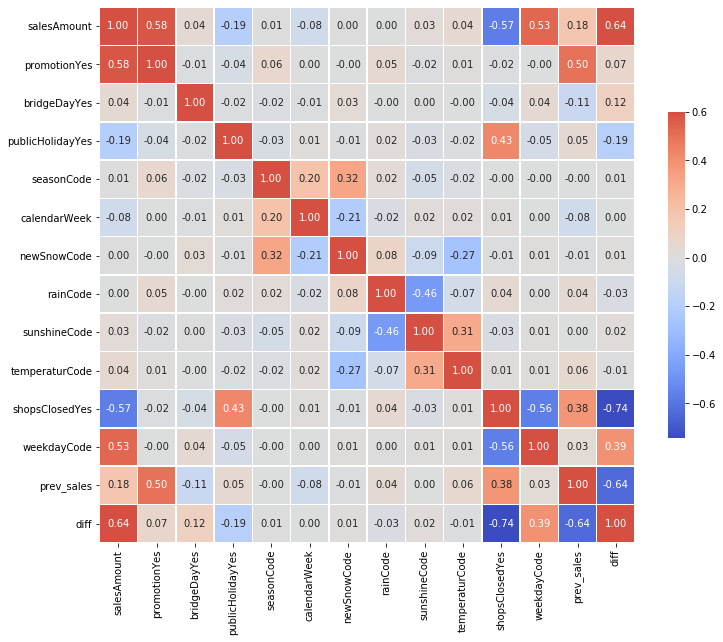

In [20]:
pearson_corr = df_diff.drop(columns, axis=1).corr(method='pearson')
hm = sns.heatmap(
    pearson_corr,
    vmax = 0.6,
    center = 0,
    square = True,
    linewidth = 0.5,
    cbar_kws = {"shrink":0.5},
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm' 
)

hm.figure.set_size_inches(12,12)
plt.show()

In [26]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    :param data: dataframe
    :param n_in: number of input to be given to the model
    :param n_out = number of output from the model
    :param dropna: to drop the nan values
    :return: the aggregated rows 
    """
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
	
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
	
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
	
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [23]:
_, _df = series_to_supervised(df)
_df.head()

,date,salesAmount,promotionYes,bridgeDayYes,publicHolidayYes,seasonCode,seasonName,calendarWeek,newSnowCode,newSnowDescription,...,newSnowDescription,rainCode,rainDescription,sunshineCode,sunShineDescription,temperaturCode,temperatureDescription,shopsClosedYes,weekdayCode,weekDayDescription
1,2012-11-01,4574.0,0.0,0.0,0.0,3.0,Herbst,44.0,0.0,kein Schnee,...,kein Schnee,4,feuchter als Mittel,4,mehr als Mittel,5,viel waermer als Mittel,0,6,Freitag
2,2012-11-02,6531.0,0.0,0.0,0.0,3.0,Herbst,44.0,0.0,kein Schnee,...,kein Schnee,3,Mittel,5,viel mehr als Mittel,5,viel waermer als Mittel,0,7,Samstag
3,2012-11-03,7291.0,0.0,0.0,0.0,3.0,Herbst,44.0,0.0,kein Schnee,...,kein Schnee,5,viel feuchter als Mittel,4,mehr als Mittel,5,viel waermer als Mittel,1,1,Sonntag
4,2012-11-04,611.0,0.0,0.0,0.0,3.0,Herbst,44.0,0.0,kein Schnee,...,kein Schnee,5,viel feuchter als Mittel,4,mehr als Mittel,4,waermer als Mittel,0,2,Montag
5,2012-11-05,4732.0,0.0,0.0,0.0,3.0,Herbst,45.0,0.0,kein Schnee,...,kein Schnee,4,feuchter als Mittel,3,Mittel,2,kaelter als Mittel,0,3,Dienstag


In [25]:
_df['salesAmount']

,salesAmount,salesAmount
1,4574.0,6531
2,6531.0,7291
3,7291.0,611
4,611.0,4732
5,4732.0,4270
...,...,...
1764,6686.0,6221
1765,6221.0,8793
1766,8793.0,12029
1767,12029.0,1606


In [27]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    """
    :param data: input dataframe
    :param data: input test split
    """
    return data[:-n_test, :], data[-n_test:, :]

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    :param y_true: expected value
    :param y_pred: predicted value
    :return: MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, model_name):
    """
    :param data: dataframe
    :param n_test: split amount for test data
    """
    predictions = list()

	# split dataset
    train, test = train_test_split(data, n_test)

    # seed history with training dataset
    history = [x for x in train]

    # step over each time-step in the test set
    for i in range(len(test)):
		# split test row into input and output columns
        testX, testy = test[i, 1:], test[i, 0]
        
        # fit model on history and make a prediction
        train_ = np.asarray(history)

        trainX, trainy = train_[:, 1:], train_[:, 0]
        model = model_dispatcher.models[model_name]
        model.fit(trainX, trainy)

        # make a one-step prediction
        yhat = model.predict([testX])
        
		# store forecast in list of predictions
        predictions.append(yhat[0])

		# add actual observation to history for the next loop
        history.append(test[i])
		    
        # summarize progress
        print('-> Expected=%.1f, Predicted=%.1f' % (testy, yhat[0]))
	
    # save the model
    #joblib.dump(model, config.MODEL_OUTPUT + model_name + '_FE_' + ".joblib")
    # estimate prediction error
    error = mean_absolute_percentage_error(test[:, 0], predictions)
    return error, test[:, 0], predictions

-> Expected=1329.0, Predicted=2062.0
-> Expected=7219.0, Predicted=12352.0
-> Expected=6479.0, Predicted=7219.0
-> Expected=5203.0, Predicted=6479.0
-> Expected=4888.0, Predicted=4992.0
-> Expected=7782.0, Predicted=7642.0
-> Expected=12439.0, Predicted=8891.0
-> Expected=1570.0, Predicted=1611.0
-> Expected=8079.0, Predicted=6479.0
-> Expected=13831.0, Predicted=8079.0
-> Expected=15893.0, Predicted=22118.0
-> Expected=14125.0, Predicted=15597.0
-> Expected=18756.0, Predicted=12700.0
-> Expected=26249.0, Predicted=17792.0
-> Expected=2366.0, Predicted=1292.0
-> Expected=15063.0, Predicted=7219.0
-> Expected=7021.0, Predicted=8615.0
-> Expected=6942.0, Predicted=7021.0
-> Expected=6899.0, Predicted=5384.0
-> Expected=10241.0, Predicted=6899.0
-> Expected=13045.0, Predicted=9076.0
-> Expected=1544.0, Predicted=1611.0
-> Expected=8261.0, Predicted=10749.0
-> Expected=5366.0, Predicted=8261.0
-> Expected=5562.0, Predicted=5366.0
-> Expected=4863.0, Predicted=6326.0
-> Expected=7223.0, Pre

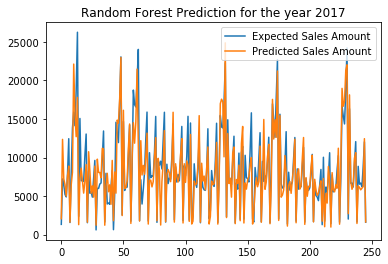

In [30]:
# load the dataset
df_ = pd.read_csv(config.INPUT_DATA + 'tomatoesAndFeatures.csv', delimiter=';', parse_dates=['date'])
df_ = df_.sort_values(by="date")
df_ = df_.drop(columns, axis=1)

# number of previous observation to consider
n_steps = 1

# get the values from the dataframe
values = df_.values

# list of models
model_list = ["random_forest"]

for model in model_list:
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=n_steps)

    # evaluate
    mae, y, yhat = walk_forward_validation(data, 246, model)
    print('MAPE: %.3f' % mae)

    # plot expected vs predicted
    plt.title('Random Forest Prediction for the year 2017')
    plt.plot(y, label='Expected Sales Amount')
    plt.plot(yhat, label='Predicted Sales Amount')
    plt.legend()
    plt.savefig(config.OUTPUT + model + '_oneStepPred_.png')
    plt.show()

## CUSTOMER PREDICTIONS VS OUR PREDICTION
### (Feature Generation for Past One Week)

In [9]:
# create customer data
df_ = pd.read_csv(config.INPUT_DATA + 'tomatoesAndFeatures.csv', delimiter=';', parse_dates=['date'])
df_prev_1_week_sales = df_.copy()
df_prev_1_week_sales['sales_before_1_week'] = df_prev_1_week_sales['salesAmount'].shift(7) 
df_prev_1_week_sales = df_prev_1_week_sales.dropna()
df_prev_1_week_sales = df_prev_1_week_sales.drop([f for f in df_prev_1_week_sales.columns if f not in ('date', 'salesAmount', 'sales_before_1_week')], axis=1)
df_prev_1_week_sales = df_prev_1_week_sales.reset_index(drop=True)

In [10]:
# save it as csv file
#df_prev_1_week_sales.to_csv(config.INPUT_DATA + 'tomatoes_CustomerData.csv', index=False)
df_prev_1_week_sales.head(10)

,date,salesAmount,sales_before_1_week
0,2012-11-08,4783,4574.0
1,2012-11-09,7285,6531.0
2,2012-11-10,8423,7291.0
3,2012-11-11,653,611.0
4,2012-11-12,4925,4732.0
5,2012-11-13,11055,4270.0
6,2012-11-14,9875,5182.0
7,2012-11-15,9133,4783.0
8,2012-11-16,13275,7285.0
9,2012-11-17,15074,8423.0


In [25]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    :param data: dataframe
    :param n_in: number of input to be given to the model
    :param n_out = number of output from the model
    :param dropna: to drop the nan values
    :return: the aggregated rows 
    """
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
	
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
	
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
	
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [26]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    """
    :param data: input dataframe
    :param data: input test split
    """
    return data[:-n_test, :], data[-n_test:, :]

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    :param y_true: expected value
    :param y_pred: predicted value
    :return: MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
def customer_prediction(data, n_test):
    """
    :param data: dataframe
    :param n_test: test splits for validation
    """
    true_ = data['salesAmount'].values
    preds_ = data['sales_before_1_week'].values
    true_, preds_ = true_[-n_test:], preds_[-n_test:]
    mae = mean_absolute_percentage_error(true_, preds_)
    return mae, true_, preds_

In [37]:
# walk-forward validation for univariate data
def walk_forward_validation(data, model_, n_test):
    """
    :param data: dataframe
    :param n_test: split amount for test data
    """
    predictions = list()

	# split dataset
    train, test = train_test_split(data, n_test)

    # seed history with training dataset
    history = [x for x in train]

    print("-----------------Our Predictions-----------------")

    # step over each time-step in the test set
    for i in range(len(test)):
		# split test row into input and output columns
        testX, testy = test[i, 1:], test[i, 0]
        
        # fit model on history and make a prediction
        train_ = np.asarray(history)
        trainX, trainy = train_[:, 1:], train_[:, 0]
        model = model_dispatcher.models[model_]
        model.fit(trainX, trainy)

        # make a one-step predicti
        yhat = model.predict([testX])
        
		# store forecast in list of predictions
        predictions.append(yhat[0])

		# add actual observation to history for the next loop
        history.append(test[i])
		    
        # summarize progress
        print('--> Expected = %.1f, Predicted = %.1f' % (testy, yhat[0]))
	
    # save the model
    with open(config.MODEL_OUTPUT + 'XGboost_5_300.pickle', 'wb') as f:
        pickle.dump(model, f, -1)
    #joblib.dump(model, config.MODEL_OUTPUT + model_ + ".joblib")
    # estimate prediction error
    mae = mean_absolute_percentage_error(test[:, 0], predictions)
    return mae, test[:, 0], predictions

-----------------Our Predictions-----------------
--> Expected = 14036.0, Predicted = 19144.0
--> Expected = 11169.0, Predicted = 16525.0
--> Expected = 11314.0, Predicted = 1025.0
--> Expected = 16986.0, Predicted = 1969.0
--> Expected = 17065.0, Predicted = 15062.0
--> Expected = 1329.0, Predicted = 2062.0
--> Expected = 7219.0, Predicted = 12352.0
--> Expected = 6479.0, Predicted = 7219.0
--> Expected = 5203.0, Predicted = 6479.0
--> Expected = 4888.0, Predicted = 5203.0
--> Expected = 7782.0, Predicted = 5287.0
--> Expected = 12439.0, Predicted = 10058.0
--> Expected = 1570.0, Predicted = 1611.0
--> Expected = 8079.0, Predicted = 8746.0
--> Expected = 13831.0, Predicted = 17405.0
--> Expected = 15893.0, Predicted = 17721.0
--> Expected = 14125.0, Predicted = 12983.0
--> Expected = 18756.0, Predicted = 22436.0
--> Expected = 26249.0, Predicted = 22973.0
--> Expected = 2366.0, Predicted = 2339.0
--> Expected = 15063.0, Predicted = 5655.0
--> Expected = 7021.0, Predicted = 6974.0
--> 

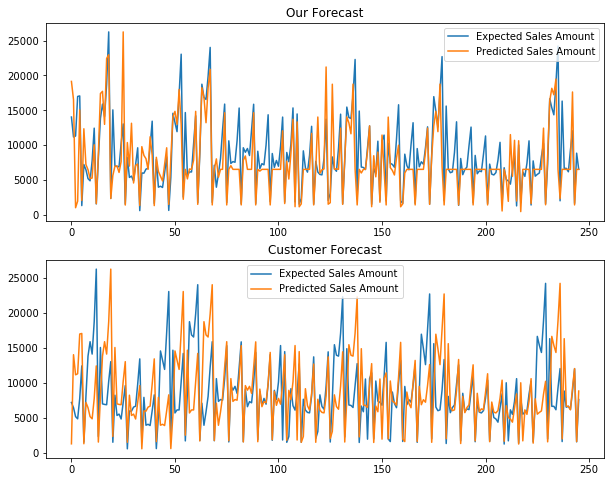

In [13]:
# # load geature generated dataset (previous day sale) 
df_orig = pd.read_csv(config.INPUT_DATA + 'tomatoesAndFeatures.csv', delimiter=';', parse_dates=['date'])
df_orig = df_orig.sort_values(by="date")
df_orig = df_orig.drop(columns, axis=1)

# number of previous observation to consider
n_steps = 6

# extract only the values from the original df
values_orig = df_orig.values

# load customer data
df_customer = pd.read_csv(config.INPUT_DATA + 'tomatoes_CustomerData.csv', delimiter=',', parse_dates=['date'])
df_customer = df_customer.sort_values(by="date")
df_customer = df_customer.drop(['date'], axis=1)

# training the random forest model only for the original data
model_ = "random_forest"

# transform the time series featured data into supervised learning
data_orig = series_to_supervised(values_orig, n_in=n_steps) 

# train the model and get predictions for the featured data
mae_orig, y_orig, yhat_orig = walk_forward_validation(data_orig, model_, n_test=246)

# get the forecast of the customers
mae_customer, y_customer, yhat_customer = customer_prediction(df_customer, n_test=246)

print('\n')
print('MAPE of Our Model: %.3f' % mae_orig)
print('MAPE of Customer Model: %.3f' % mae_customer)
print('\n')

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Our Forecast')
ax1.plot(y_orig, label='Expected Sales Amount')
ax1.plot(yhat_orig, label='Predicted Sales Amount')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(212)
ax2.set_title('Customer Forecast')
ax2.plot(y_customer, label='Expected Sales Amount')
ax2.plot(yhat_customer, label='Predicted Sales Amount')
ax2.legend(loc='upper right')

plt.legend()
plt.savefig(config.OUTPUT + model_ + '_customerVSourmodel_2.png')
plt.show()

In [30]:
df_test = pd.read_csv(config.INPUT_DATA + 'tomatoesAndFeatures.csv', delimiter=';', parse_dates=['date'])
df_test = df_test.sort_values(by="date")
#df_test = df_test.drop(columns, axis=1)

val_ = df_test.values

In [33]:
df_test_week_sales = df_test.copy()
df_test_week_sales['sales_before_1_week'] = df_test_week_sales['salesAmount'].shift(7) 
df_test_week_sales = df_test_week_sales.dropna()
df_test_week_sales = df_test_week_sales.drop([f for f in df_test_week_sales.columns if f not in ('date', 'salesAmount', 'sales_before_1_week')], axis=1)
df_test_week_sales = df_test_week_sales.reset_index(drop=True)

In [34]:
df_test_week_sales.tail(10)

,date,salesAmount,sales_before_1_week
1752,2017-08-26,12060,24216.0
1753,2017-08-27,1641,2015.0
1754,2017-08-28,8854,16324.0
1755,2017-08-29,6540,6669.0
1756,2017-08-30,6686,6676.0
1757,2017-08-31,6221,6182.0
1758,2017-09-01,8793,9304.0
1759,2017-09-02,12029,12060.0
1760,2017-09-03,1606,1641.0
1761,2017-09-04,7637,8854.0


In [12]:
df_orig = pd.read_csv(config.INPUT_DATA + 'tomatoesAndFeatures.csv', delimiter=';', parse_dates=['date'])
df_orig = df_orig.sort_values(by="date")

# extract only the values from the original df
values_orig = df_orig.values

# load customer data
df_customer = pd.read_csv(config.INPUT_DATA + 'tomatoes_CustomerData.csv', delimiter=',', parse_dates=['date'])
df_customer = df_customer.sort_values(by="date")

In [44]:
new_data = series_to_supervised(df_orig, n_in=6)
new_data.columns[new_data.columns.duplicated(keep=False)]

Index(['date', 'salesAmount', 'promotionYes', 'bridgeDayYes',
       'publicHolidayYes', 'seasonCode', 'seasonName', 'calendarWeek',
       'newSnowCode', 'newSnowDescription',
       ...
       'newSnowDescription', 'rainCode', 'rainDescription', 'sunshineCode',
       'sunShineDescription', 'temperaturCode', 'temperatureDescription',
       'shopsClosedYes', 'weekdayCode', 'weekDayDescription'],
      dtype='object', length=133)